In [37]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import openpyxl

#Import pipeline functions
import recist_and_volume_calculator as rc


In [38]:
#lets open a test image
path = '/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/Processed/Lung_Dx-A0012_(DL)'
image = sitk.ReadImage(os.path.join(path,'image.nrrd'))
spacing = image.GetSpacing()
image_array = sitk.GetArrayFromImage(image)
dl_mask_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path,'DL_mask.nrrd')))

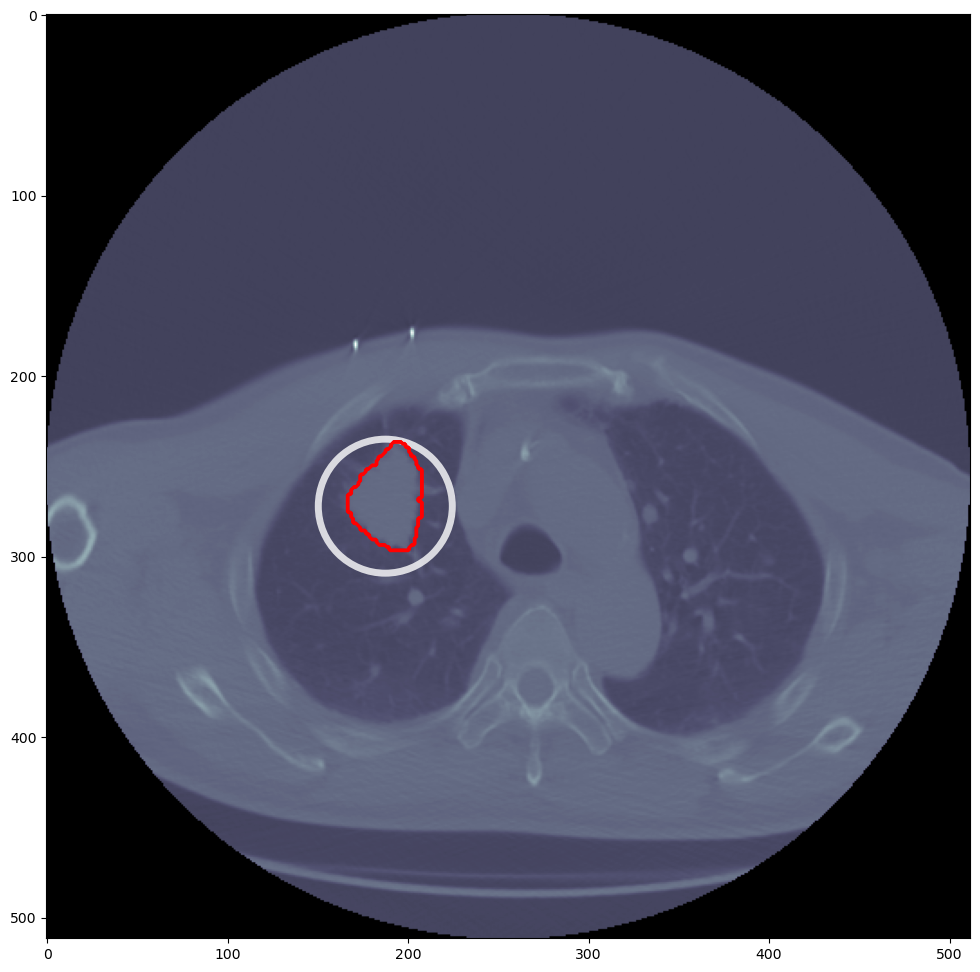

----------------------------------------
Predicted RECIST: 42 mm
Predicted tumor volume: 17.33 ml
----------------------------------------


In [39]:
##Calculate metrics
recist_predicted,volume_predicted,idx,circle = rc.calculate_values(dl_mask_array,spacing)
circle1 = plt.Circle((circle[1], circle[0]), circle[2]*2, color='white',fill=False,alpha=0.8, lw=5)

plt.figure(figsize=(12,12))
plt.imshow(image_array[idx,...],cmap='bone')
plt.contour(dl_mask_array[idx,...],colors='r')
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(circle1)
plt.show()

print('-'*40)
print('Predicted RECIST: %s mm'%recist_predicted) 
print('Predicted tumor volume: %s ml'%volume_predicted)
print('-'*40)

In [40]:

def extract_subject_id(id_string):
    if isinstance(id_string, str):
        # Recherche du pattern A suivi de chiffres
        match = re.search(r'A\d+', id_string)
        if match:
            return match.group(0)
    return None

In [41]:
# Stage ranking to map T-stage to a numerical scale
stage_order = {
    '0': 0,
    '1a': 1,
    '1b': 2,
    '1c': 3,
    '2a': 4,
    '2b': 5,
    '3': 6,
    '4': 7
}


def get_correct_t_stage(size_mm):
    if size_mm == 0:
        return '0'
    elif size_mm <= 10:
        return '1a'
    elif size_mm <= 20:
        return '1b'
    elif size_mm <= 30:
        return '1c'
    elif size_mm <= 40:
        return '2a'
    elif size_mm <= 50:
        return '2b'
    elif size_mm <= 70:
        return '3'
    else:
        return '4'

# Implementation of an other way to compute the size of the tumor - based on the ouputs of Alternative_mesurements.py

In [ ]:
whole_data_predicted=pd.read_csv('/usr/users/pred_lung_cancer/piquet_con/Project-lung-cancer/Model_1/T_Stage_Classification/patient_volume_summaries_comparison.csv')
clinical_data = pd.read_excel('/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/statistics-clinical-20201221.xlsx')

whole_data_predicted['NewPatientID'] = whole_data_predicted['patient_id'].apply(extract_subject_id)
t_stage_data = clinical_data[['NewPatientID', 'T-Stage']]

# Merge the dataframes to get T-stage for each patient
whole_combined_data = pd.merge(
    whole_data_predicted[['NewPatientID', 'max_recist_mm_A', 'max_recist_mm_B']], 
    t_stage_data,
    on='NewPatientID',
    how='inner'  
)

print("\nCombined data (T-stage and all methods measures):")
print(whole_combined_data)


Combined data (T-stage and all methods measures):
    NewPatientID  max_recist_mm_A  max_recist_mm_B T-Stage
0          A0200               31        30.985206      1c
1          A0096               14        13.998876      1c
2          A0071               64        64.178598       2
3          A0107               38        37.786033      1c
4          A0142               35        35.506769       2
..           ...              ...              ...     ...
187        A0139               94        93.287305       4
188        A0144               84        84.341514       2
189        A0090               47        47.336152      1c
190        A0036               34        34.172164      1c
191        A0044               31        29.933701      1c

[192 rows x 4 columns]


In [43]:
# Apply function to compute correct T-stage
whole_combined_data['recist-stage'] = whole_combined_data['max_recist_mm_A'].apply(get_correct_t_stage)
whole_combined_data['ellipsoid-stage'] = whole_combined_data['max_recist_mm_B'].apply(get_correct_t_stage)

# Compare recist-stage vs T-Stage
whole_combined_data['Recist_Match'] = np.where(
    whole_combined_data['T-Stage'].astype(str).str.strip().str.len() == 1,
    # If T-Stage is single character, compare first characters
    whole_combined_data['recist-stage'].astype(str).str.strip().str[0] == 
    whole_combined_data['T-Stage'].astype(str).str.strip().str[0],
    # If T-Stage is multi-character, compare full strings
    whole_combined_data['recist-stage'].astype(str).str.strip() == 
    whole_combined_data['T-Stage'].astype(str).str.strip()
)

# Compare ellipsoid-stage vs T-Stage
whole_combined_data['Ellipsoid_Match'] = np.where(
    whole_combined_data['T-Stage'].astype(str).str.strip().str.len() == 1,
    # If T-Stage is single character, compare first characters
    whole_combined_data['ellipsoid-stage'].astype(str).str.strip().str[0] == 
    whole_combined_data['T-Stage'].astype(str).str.strip().str[0],
    # If T-Stage is multi-character, compare full strings
    whole_combined_data['ellipsoid-stage'].astype(str).str.strip() == 
    whole_combined_data['T-Stage'].astype(str).str.strip()
)

# Output results
print("Full Verification Table:")
print(whole_combined_data)

Full Verification Table:
    NewPatientID  max_recist_mm_A  max_recist_mm_B T-Stage recist-stage  \
0          A0200               31        30.985206      1c           2a   
1          A0096               14        13.998876      1c           1b   
2          A0071               64        64.178598       2            3   
3          A0107               38        37.786033      1c           2a   
4          A0142               35        35.506769       2           2a   
..           ...              ...              ...     ...          ...   
187        A0139               94        93.287305       4            4   
188        A0144               84        84.341514       2            4   
189        A0090               47        47.336152      1c           2b   
190        A0036               34        34.172164      1c           2a   
191        A0044               31        29.933701      1c           2a   

    ellipsoid-stage  Recist_Match  Ellipsoid_Match  
0                2a  

In [44]:
def compute_error(row, stage_column='recist-stage'):
    """
    Compute error between predicted and actual T-stage.
    
    Parameters:
    row: pandas Series representing a row of data
    stage_column: str, either 'recist-stage' or 'ellipsoid-stage'
    """
    # Determine which match column to use
    match_column = 'Recist_Match' if stage_column == 'recist-stage' else 'Ellipsoid_Match'
    
    if not row[match_column]:
        try:
            model_stage = str(row[stage_column]).strip().lower()
            actual_stage = str(row['T-Stage']).strip().lower()

            # Handle special case: if actual T-Stage is exactly "2", treat it as "2a"
            if actual_stage == '2':
                actual_stage = '2a'

            actual = int(stage_order.get(actual_stage, -1))
            predicted = int(stage_order.get(model_stage, -1))

            return abs(actual - predicted)
        except (ValueError, TypeError):
            return np.nan
    else:
        return 0

In [45]:
# Compute errors for both methods
whole_combined_data['Recist_Error'] = whole_combined_data.apply(
    lambda row: compute_error(row, 'recist-stage'), axis=1
)

whole_combined_data['Ellipsoid_Error'] = whole_combined_data.apply(
    lambda row: compute_error(row, 'ellipsoid-stage'), axis=1
)

In [46]:
# Output results
print("Full Verification Table:")
print(whole_combined_data)

Full Verification Table:
    NewPatientID  max_recist_mm_A  max_recist_mm_B T-Stage recist-stage  \
0          A0200               31        30.985206      1c           2a   
1          A0096               14        13.998876      1c           1b   
2          A0071               64        64.178598       2            3   
3          A0107               38        37.786033      1c           2a   
4          A0142               35        35.506769       2           2a   
..           ...              ...              ...     ...          ...   
187        A0139               94        93.287305       4            4   
188        A0144               84        84.341514       2            4   
189        A0090               47        47.336152      1c           2b   
190        A0036               34        34.172164      1c           2a   
191        A0044               31        29.933701      1c           2a   

    ellipsoid-stage  Recist_Match  Ellipsoid_Match  Recist_Error  \
0     

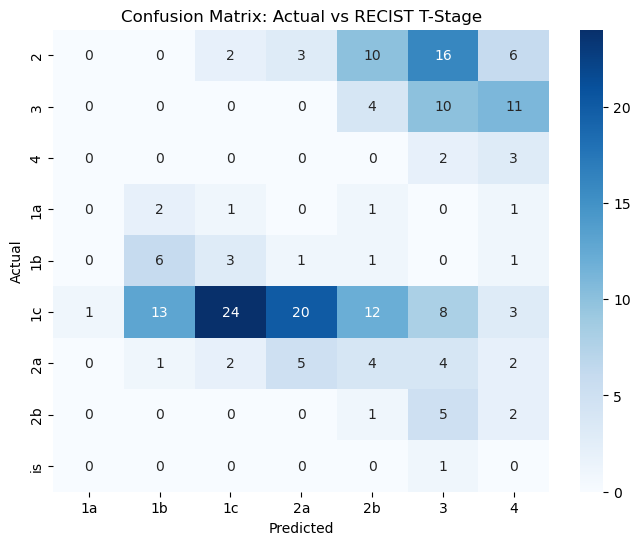

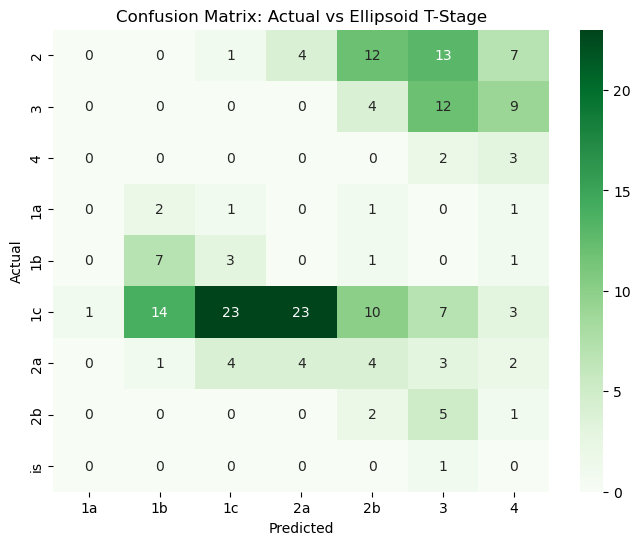

In [56]:
# Confusion Matrix Generation for T-Stage Predictions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrices
def create_confusion_matrices(data):
    """Create and display confusion matrices for RECIST and Ellipsoid predictions"""
    
    # Create subplots for both confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    # Confusion matrix: actual vs predicted - RECIST
    conf_matrix_recist = pd.crosstab(data['T-Stage'], data['recist-stage'])
    sns.heatmap(conf_matrix_recist, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title('Confusion Matrix: Actual vs RECIST T-Stage')
    axes[0].set_xlabel('RECIST Prediction')
    axes[0].set_ylabel('Actual T-Stage')
    
    # Confusion matrix: actual vs predicted - Ellipsoid
    conf_matrix_ellipsoid = pd.crosstab(data['T-Stage'], data['ellipsoid-stage'])
    sns.heatmap(conf_matrix_ellipsoid, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title('Confusion Matrix: Actual vs Ellipsoid T-Stage')
    axes[1].set_xlabel('Ellipsoid Prediction')
    axes[1].set_ylabel('Actual T-Stage')
    
    plt.tight_layout()
    plt.show()
    
    return conf_matrix_recist, conf_matrix_ellipsoid

# Alternative: Create individual confusion matrices
def create_individual_confusion_matrix(data, actual_col, predicted_col, title, cmap="Blues"):
    """Create a single confusion matrix"""
    conf_matrix = pd.crosstab(data[actual_col], data[predicted_col])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return conf_matrix

recist_cm = create_individual_confusion_matrix(
     whole_combined_data, 'T-Stage', 'recist-stage', 
     'Confusion Matrix: Actual vs RECIST T-Stage', 'Blues'
 )
 
ellipsoid_cm = create_individual_confusion_matrix(
     whole_combined_data, 'T-Stage', 'ellipsoid-stage',
     'Confusion Matrix: Actual vs Ellipsoid T-Stage', 'Greens'
 )

         COMPREHENSIVE METHOD COMPARISON
                       RECIST Ellipsoid
Total Cases               192       192
Correct Predictions        62        67
Incorrect Predictions     130       125
Accuracy               32.29%    34.90%
Error Rate             67.71%    65.10%
Mean Stage Error        1.193     1.125
Median Stage Error      1.000     1.000
Std Stage Error         1.197     1.200
Max Stage Error           7.0       7.0
Min Stage Error           0.0       0.0
Zero Predictions            0         0

📊 PERFORMANCE DIFFERENCES:
Accuracy Difference (RECIST - Ellipsoid): -2.60%
Mean Error Difference (RECIST - Ellipsoid): +0.068
✅ Ellipsoid method is 2.60% more accurate

📈 ERROR ANALYSIS BY T-STAGE:
         RECIST_Mean_Error  RECIST_Count  Ellipsoid_Mean_Error  \
T-Stage                                                          
2                    1.405            37                 1.297   
3                    0.600            25                 0.520   
4              

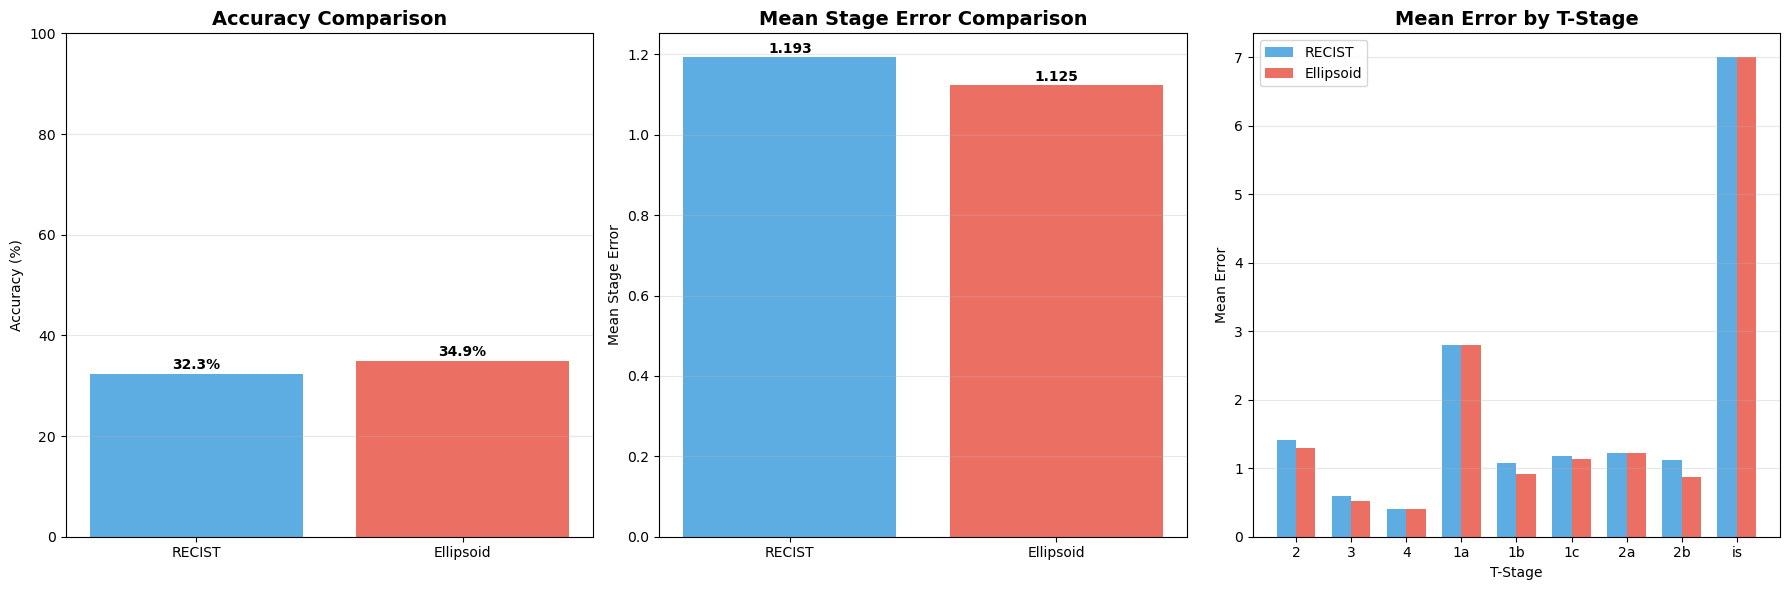


💾 FILES SAVED:
✅ method_comparison_summary.csv
✅ error_comparison_by_stage.csv


In [51]:
def comprehensive_method_comparison(data):
    """
    Comprehensive comparison between RECIST and Ellipsoid methods
    """
    
    # Calculate basic statistics for both methods
    def get_method_stats(data, stage_col, match_col, error_col):
        stats = {}
        stats['total_cases'] = len(data)
        stats['correct_predictions'] = data[match_col].sum()
        stats['incorrect_predictions'] = stats['total_cases'] - stats['correct_predictions']
        stats['accuracy'] = (stats['correct_predictions'] / stats['total_cases']) * 100
        stats['error_rate'] = 100 - stats['accuracy']
        stats['mean_error'] = data[error_col].mean()
        stats['median_error'] = data[error_col].median()
        stats['std_error'] = data[error_col].std()
        stats['max_error'] = data[error_col].max()
        stats['min_error'] = data[error_col].min()
        stats['zero_predictions'] = data[stage_col].astype(str).str.strip().eq('0').sum()
        return stats
    
    # Get statistics for both methods
    recist_stats = get_method_stats(data, 'recist-stage', 'Recist_Match', 'Recist_Error')
    ellipsoid_stats = get_method_stats(data, 'ellipsoid-stage', 'Ellipsoid_Match', 'Ellipsoid_Error')
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'RECIST': [
            recist_stats['total_cases'],
            recist_stats['correct_predictions'],
            recist_stats['incorrect_predictions'],
            f"{recist_stats['accuracy']:.2f}%",
            f"{recist_stats['error_rate']:.2f}%",
            f"{recist_stats['mean_error']:.3f}",
            f"{recist_stats['median_error']:.3f}",
            f"{recist_stats['std_error']:.3f}",
            f"{recist_stats['max_error']:.1f}",
            f"{recist_stats['min_error']:.1f}",
            recist_stats['zero_predictions']
        ],
        'Ellipsoid': [
            ellipsoid_stats['total_cases'],
            ellipsoid_stats['correct_predictions'],
            ellipsoid_stats['incorrect_predictions'],
            f"{ellipsoid_stats['accuracy']:.2f}%",
            f"{ellipsoid_stats['error_rate']:.2f}%",
            f"{ellipsoid_stats['mean_error']:.3f}",
            f"{ellipsoid_stats['median_error']:.3f}",
            f"{ellipsoid_stats['std_error']:.3f}",
            f"{ellipsoid_stats['max_error']:.1f}",
            f"{ellipsoid_stats['min_error']:.1f}",
            ellipsoid_stats['zero_predictions']
        ]
    }, index=[
        'Total Cases',
        'Correct Predictions',
        'Incorrect Predictions', 
        'Accuracy',
        'Error Rate',
        'Mean Stage Error',
        'Median Stage Error',
        'Std Stage Error',
        'Max Stage Error',
        'Min Stage Error',
        'Zero Predictions'
    ])
    
    print("="*60)
    print("         COMPREHENSIVE METHOD COMPARISON")
    print("="*60)
    print(comparison_df)
    print("="*60)
    
    # Performance difference analysis
    accuracy_diff = recist_stats['accuracy'] - ellipsoid_stats['accuracy']
    mean_error_diff = recist_stats['mean_error'] - ellipsoid_stats['mean_error']
    
    print(f"\n📊 PERFORMANCE DIFFERENCES:")
    print(f"Accuracy Difference (RECIST - Ellipsoid): {accuracy_diff:+.2f}%")
    print(f"Mean Error Difference (RECIST - Ellipsoid): {mean_error_diff:+.3f}")
    
    if accuracy_diff > 0:
        print(f"✅ RECIST method is {accuracy_diff:.2f}% more accurate")
    elif accuracy_diff < 0:
        print(f"✅ Ellipsoid method is {abs(accuracy_diff):.2f}% more accurate")
    else:
        print("🤝 Both methods have equal accuracy")
    
    # Error analysis by T-Stage
    print(f"\n📈 ERROR ANALYSIS BY T-STAGE:")
    recist_errors_by_stage = data.groupby('T-Stage')['Recist_Error'].agg(['mean', 'count']).round(3)
    ellipsoid_errors_by_stage = data.groupby('T-Stage')['Ellipsoid_Error'].agg(['mean', 'count']).round(3)
    
    error_comparison = pd.DataFrame({
        'RECIST_Mean_Error': recist_errors_by_stage['mean'],
        'RECIST_Count': recist_errors_by_stage['count'],
        'Ellipsoid_Mean_Error': ellipsoid_errors_by_stage['mean'],
        'Ellipsoid_Count': ellipsoid_errors_by_stage['count']
    })
    error_comparison['Difference'] = (error_comparison['RECIST_Mean_Error'] - 
                                    error_comparison['Ellipsoid_Mean_Error']).round(3)
    print(error_comparison)
    
    # Create visualizations (3 plots total)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Accuracy Comparison
    methods = ['RECIST', 'Ellipsoid']
    accuracies = [recist_stats['accuracy'], ellipsoid_stats['accuracy']]
    bars1 = axes[0].bar(methods, accuracies, color=['#3498db', '#e74c3c'], alpha=0.8)
    axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
    
    # 2. Mean Error Comparison
    mean_errors = [recist_stats['mean_error'], ellipsoid_stats['mean_error']]
    bars2 = axes[1].bar(methods, mean_errors, color=['#3498db', '#e74c3c'], alpha=0.8)
    axes[1].set_title('Mean Stage Error Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Mean Stage Error')
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(mean_errors):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
    
    # 3. Error by T-Stage
    stages = error_comparison.index
    x_pos = np.arange(len(stages))
    width = 0.35
    
    bars1 = axes[2].bar(x_pos - width/2, error_comparison['RECIST_Mean_Error'], 
                          width, label='RECIST', color='#3498db', alpha=0.8)
    bars2 = axes[2].bar(x_pos + width/2, error_comparison['Ellipsoid_Mean_Error'], 
                          width, label='Ellipsoid', color='#e74c3c', alpha=0.8)
    
    axes[2].set_title('Mean Error by T-Stage', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('T-Stage')
    axes[2].set_ylabel('Mean Error')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(stages)
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save comparison report
    comparison_df.to_csv("method_comparison_summary.csv")
    error_comparison.to_csv("error_comparison_by_stage.csv")
    
    print(f"\n💾 FILES SAVED:")
    print("✅ method_comparison_summary.csv")
    print("✅ error_comparison_by_stage.csv")
    
    return comparison_df, error_comparison

# Run the comprehensive comparison
comparison_summary, stage_errors = comprehensive_method_comparison(whole_combined_data)